# Predicting Flare Spectra

This notebook shows predicted MOXSI spectra for several different reference spectra:

- CHIANTI "flare_ext.dem"
- Caspi et al. (2010,2014) flare spectra for the following flare classes:
    - A1
    - B1
    - B7
    - C1
    - M1
    - M5
    - X5
 
Line identifications from a curated line list are included in each plot. All MOXSI spectral orders are included. 

In [1]:
import asdf
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import get_earth, Helioprojective
import astropy.table
from astropy.visualization import quantity_support
from fiasco.io import Parser
import ndcube

from mocksipipeline.physics.spectral import get_spectral_tables, calculate_intensity
from mocksipipeline.detector.component import compute_flux_point_source, dem_table_to_ndcube, blur_spectra
from mocksipipeline.detector.response import get_all_dispersed_channels

ModuleNotFoundError: No module named 'asdf'

In [2]:
def annotate_lines(axis, channels, location, line_list, data_channel, data_total, rel_tol=1e-1, abs_tol=1e-3, **kwargs):
    for i, (chan, data) in enumerate(zip(channels, data_channel)):
        line_pos, _, _ = chan.get_wcs(location.observer, **kwargs).world_to_pixel(location, line_list['wavelength'])
        _, _, line_index = chan.get_wcs(location.observer, **kwargs).world_to_array_index(location, line_list['wavelength'])
        color = f'C{i}'
        for pos, index, row in zip(line_pos, line_index, line_list):
            if index >= data.shape[0] or data[index] < data_total[index]*rel_tol or data_total[index] < data_total.max()*abs_tol:
                continue
            text_ypos = 150
            axis.annotate(
                f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline", precision=5)}',
                (pos, data[index]),
                xytext=(0, 150),
                textcoords='offset points',
                rotation=90,
                color=color,
                horizontalalignment='center',
                verticalalignment='center',
                arrowprops=dict(color=color, arrowstyle='-', ls='--'),
            )


def plot_spectrum(intensity, channels, location, title=None, line_list=None, y_lim=None, blur=None, log_y=True, x_lim=None, rel_tol=1e-1, abs_tol=1e-3, **kwargs):
    flux = compute_flux_point_source(intensity,
                                     location,
                                     channels=channels,
                                     blur=blur,
                                     electrons=False,
                                     include_gain=False,
                                     **kwargs)    
    pix_grid = np.arange(0,2000,1)
    fig = plt.figure(figsize=(25,5))
    ax = fig.add_subplot()
    total = np.zeros(pix_grid.shape)
    components = []
    for chan in channels:
        x_,_,_ = chan.get_wcs(location.observer, **kwargs).world_to_pixel(location, chan.wavelength)
        y = flux[f'order_{chan.spectral_order}']
        if blur:
            y = blur_spectra(y, blur, chan)
        y_interp = interp1d(x_, y.data, kind='linear', bounds_error=False, fill_value=0)(pix_grid)
        components.append(y_interp)
        total += y_interp
        ax.plot(pix_grid, y_interp, label=f'order={chan.spectral_order}')
    ax.plot(pix_grid, total, color='k', ls='-', label='total', alpha=0.75)
    ax.axhline(y=1, color='k', ls=':')
    if line_list:
        annotate_lines(ax, channels, location, line_list, components, total, rel_tol=rel_tol, abs_tol=abs_tol, **kwargs)
    if log_y:
        ax.set_yscale('log')
    ax.set_xlim((1000, 2000) if x_lim is None else x_lim)
    if y_lim is None:
        y_lim = (0, total.max()*1.025)
    ax.set_ylim(y_lim)
    ax.set_ylabel(f"Flux [{flux['total'].unit:latex}]")
    ax.set_xlabel('Dispersion direction [pixel]')
    ax.legend(loc=4 if log_y else 1, ncol=5, frameon=False)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    if title is not None:
        ax.set_title(title)

## Load and Compute Reference Spectra

### CHIANTI Spectra

In [3]:
chianti_dir = '/Users/wtbarnes/ssw/packages/chianti/dbase/'
dem_flare_ext = dem_table_to_ndcube(Parser('flare_ext.dem', ascii_dbase_root=chianti_dir).parse())
spec_tables = get_spectral_tables()
chianti_flare_ext_coronal_spectrum = calculate_intensity(dem_flare_ext, spec_tables['sun_coronal_1992_feldman_ext_all'], {})
chianti_flare_ext_photospheric_spectrum = calculate_intensity(dem_flare_ext, spec_tables['sun_photospheric_2015_scott_all'], {})

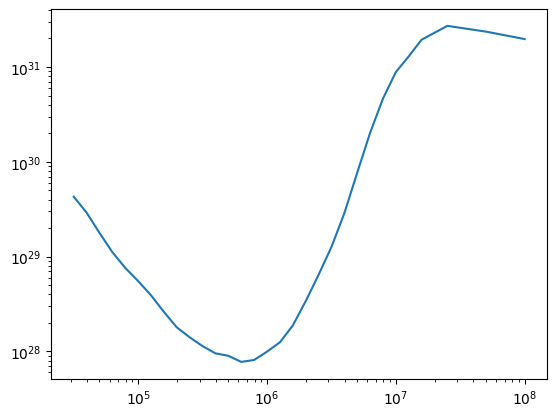

In [4]:
plt.plot(dem_flare_ext.axis_world_coords(0)[0], dem_flare_ext.data)
plt.xscale('log')
plt.yscale('log')

### Caspi et al. flare spectra

In [5]:
goes_class = ['a1', 'b1', 'b7', 'c1', 'm1', 'm5', 'x5']
caspi_spectrum = []
with asdf.open('../data/reference_spectra/caspi_flare_spectra.asdf') as af:
    for gc in goes_class:
        caspi_spectrum.append((gc, ndcube.NDCube(af.tree[gc]['data'], wcs=af.tree[gc]['wcs'])))
caspi_spectrum = ndcube.NDCollection(caspi_spectrum, aligned_axes=(0,))

Let's compare all of the spectra

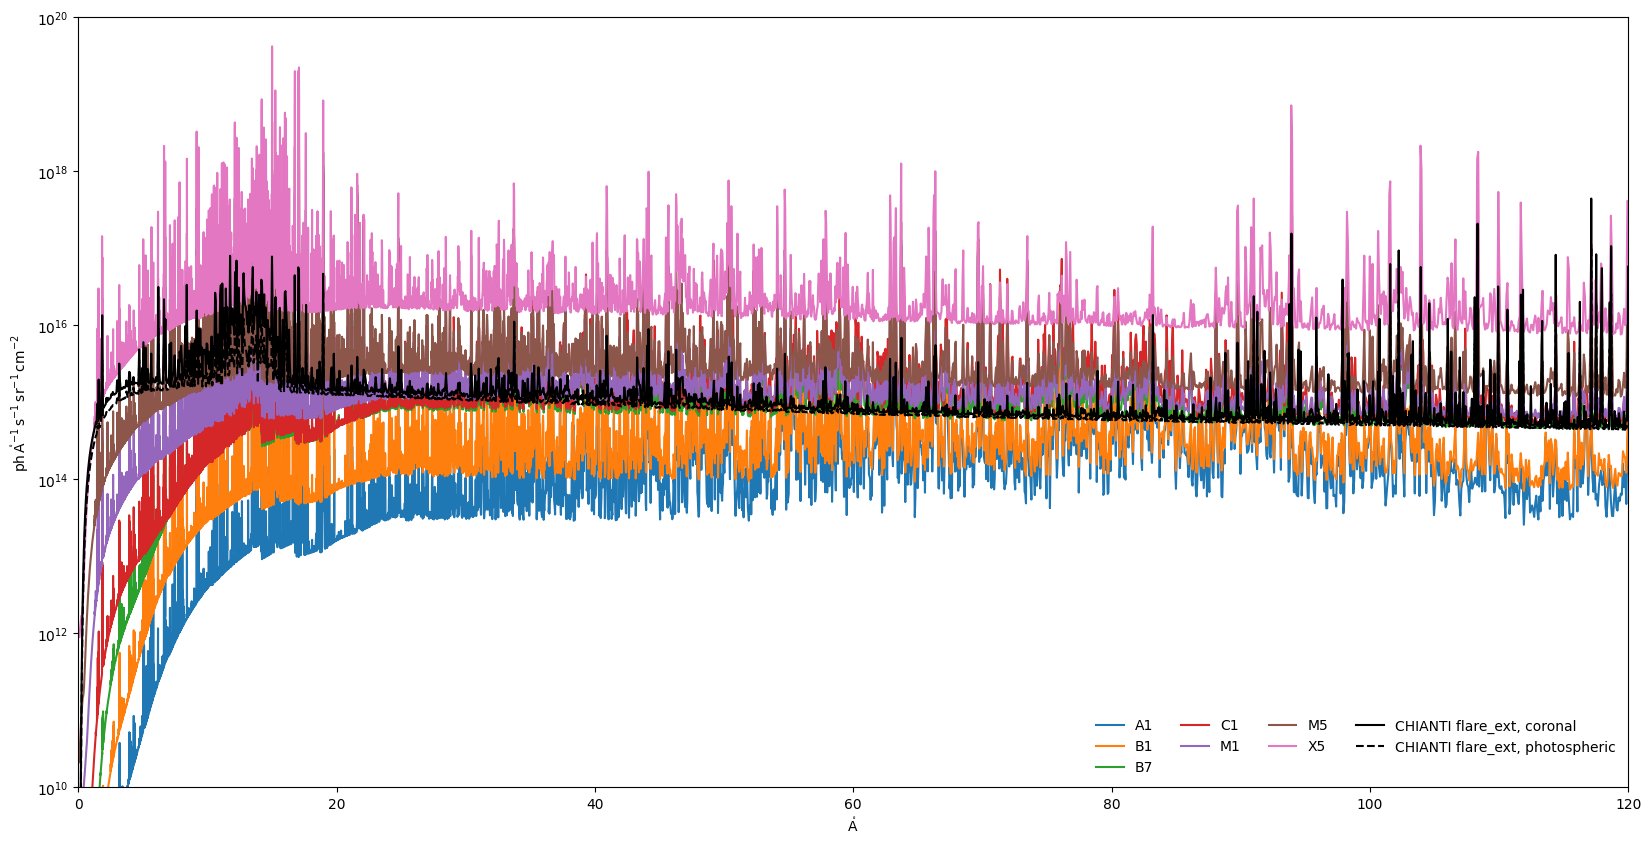

In [19]:
plt.figure(figsize=(20,10))
with quantity_support():
    for k in caspi_spectrum:
        plt.plot(caspi_spectrum[k].axis_world_coords(0)[0].to('AA', equivalencies=u.spectral()),
                 caspi_spectrum[k].data*caspi_spectrum[k].unit, label=k.upper())
    plt.plot(chianti_flare_ext_coronal_spectrum.axis_world_coords(0)[0].to('AA'),
         chianti_flare_ext_coronal_spectrum.data*chianti_flare_ext_coronal_spectrum.unit, color='k', label='CHIANTI flare_ext, coronal')
    plt.plot(chianti_flare_ext_photospheric_spectrum.axis_world_coords(0)[0].to('AA'),
         chianti_flare_ext_photospheric_spectrum.data*chianti_flare_ext_photospheric_spectrum.unit, color='k', ls='--', label='CHIANTI flare_ext, photospheric')
plt.xlim(0,120)
plt.yscale('log')
plt.ylim(1e10,1e20)
plt.legend(loc=4, ncol=4, frameon=False)

## Load line list

In [7]:
line_list = astropy.table.QTable.read('../data/line_lists/curated_line_list.asdf')

## MOXSI Fluxes

Compute flux MOXSI would observe, assuming a point source. We first need to define a few parameters in order to compute the MOXSI flux.

In [8]:
earth_observer = get_earth(time='2020-01-01 12:00:00')

In [9]:
source_location = SkyCoord(Tx=0*u.arcsec,
                           Ty=0*u.arcsec,
                           frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))

In [10]:
all_channels = get_all_dispersed_channels()

In [11]:
roll_angle = 0 * u.deg

In [12]:
blur = 40 * u.arcsec / all_channels[0].resolution[0] * all_channels[0].spectral_resolution

### CHIANTI

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


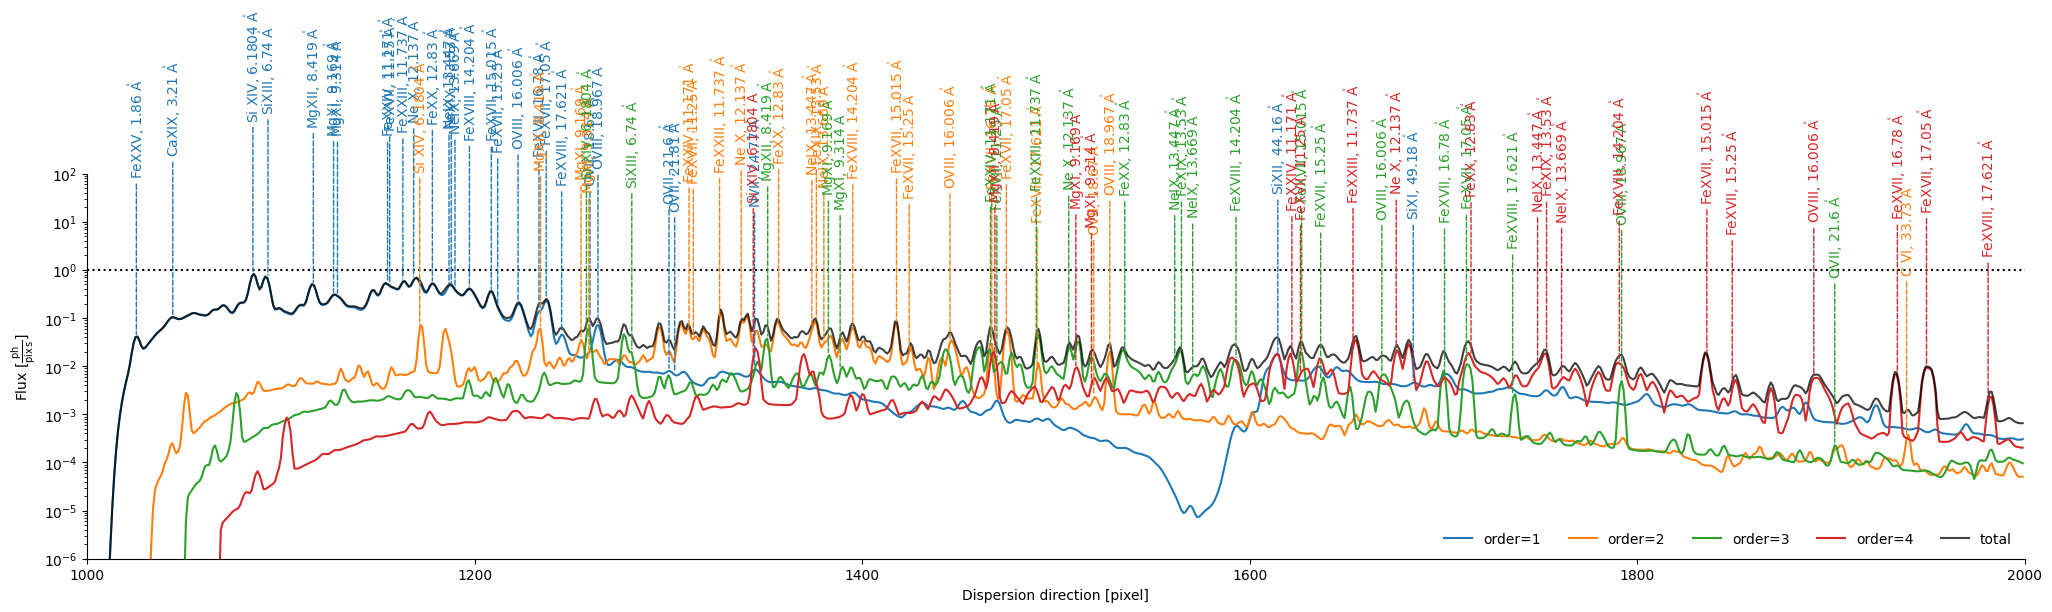

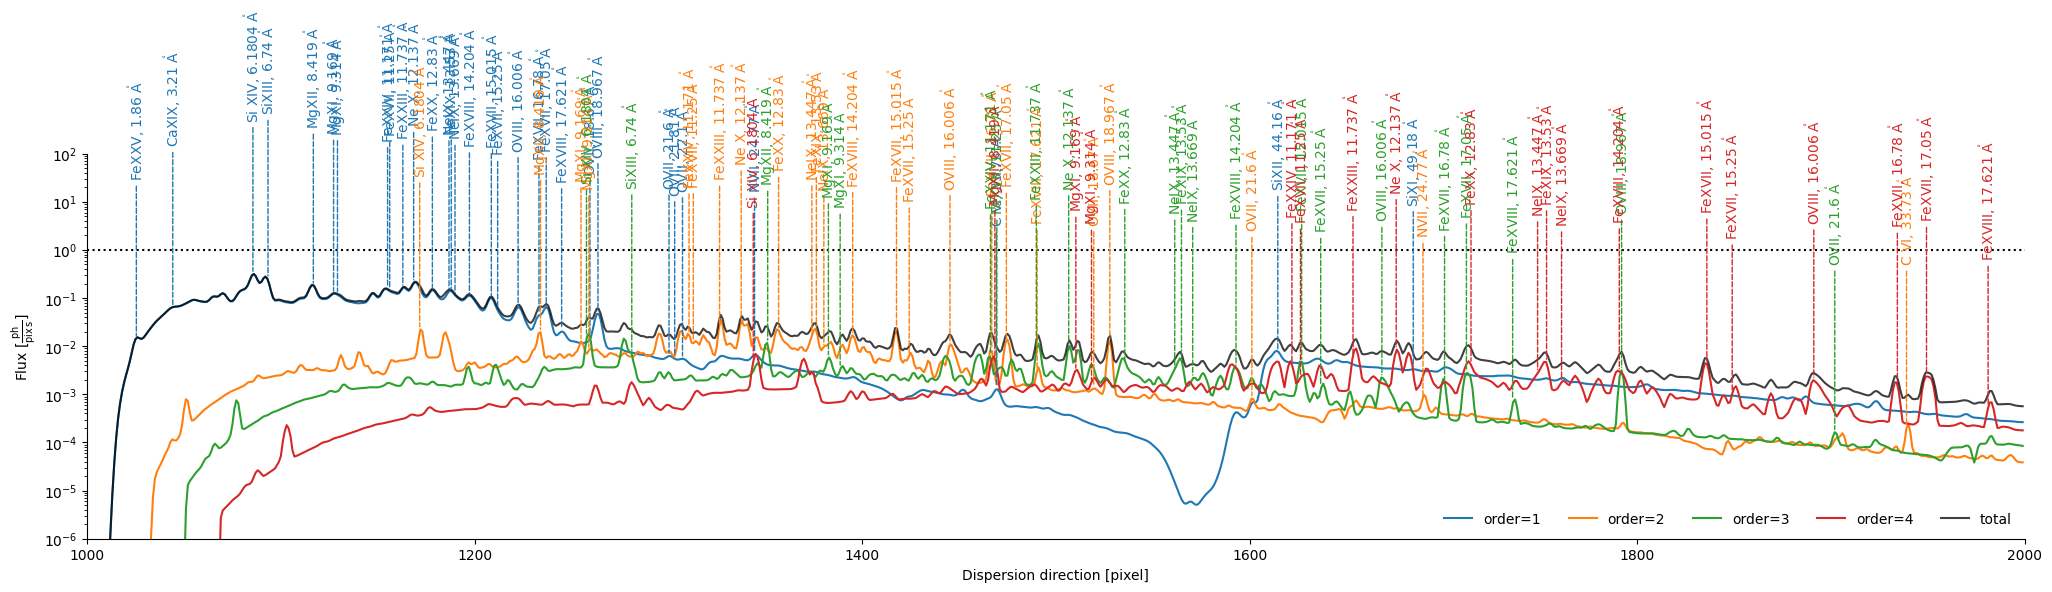

In [13]:
for chianti_spec in [chianti_flare_ext_coronal_spectrum, chianti_flare_ext_photospheric_spectrum]:
    plot_spectrum(chianti_spec,
                  all_channels[5:],
                  source_location, 
                  line_list=line_list, 
                  blur=blur,
                  y_lim=(1e-6,1e2),
                  log_y=True,
                  x_lim=(1000,2000),
                  roll_angle=roll_angle,
                  rel_tol=1e-1, abs_tol=1e-3)

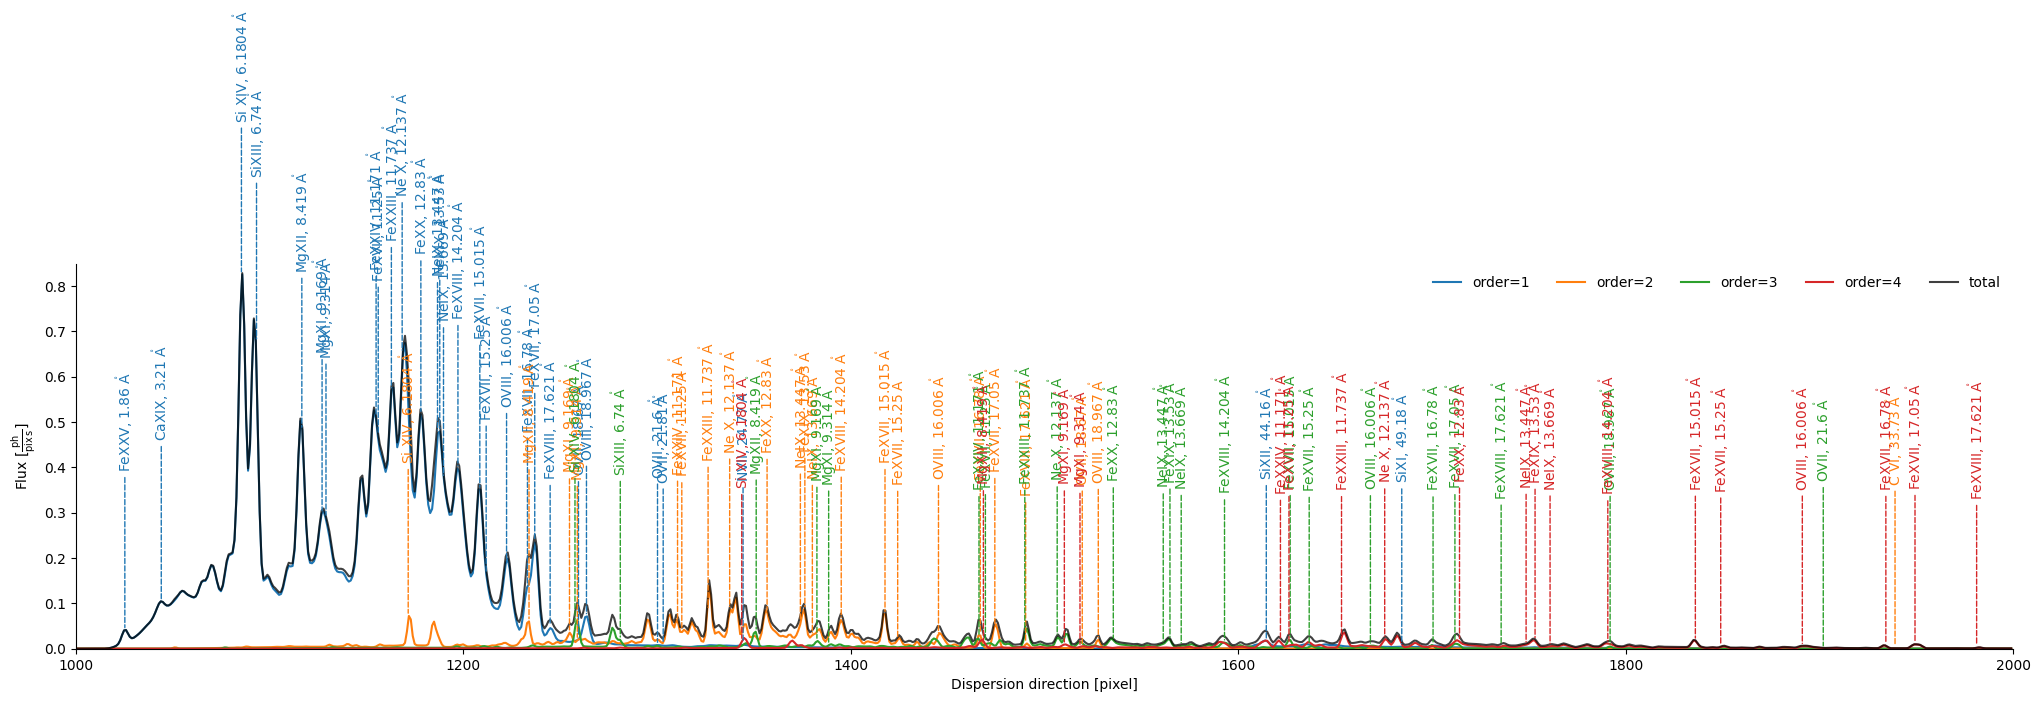

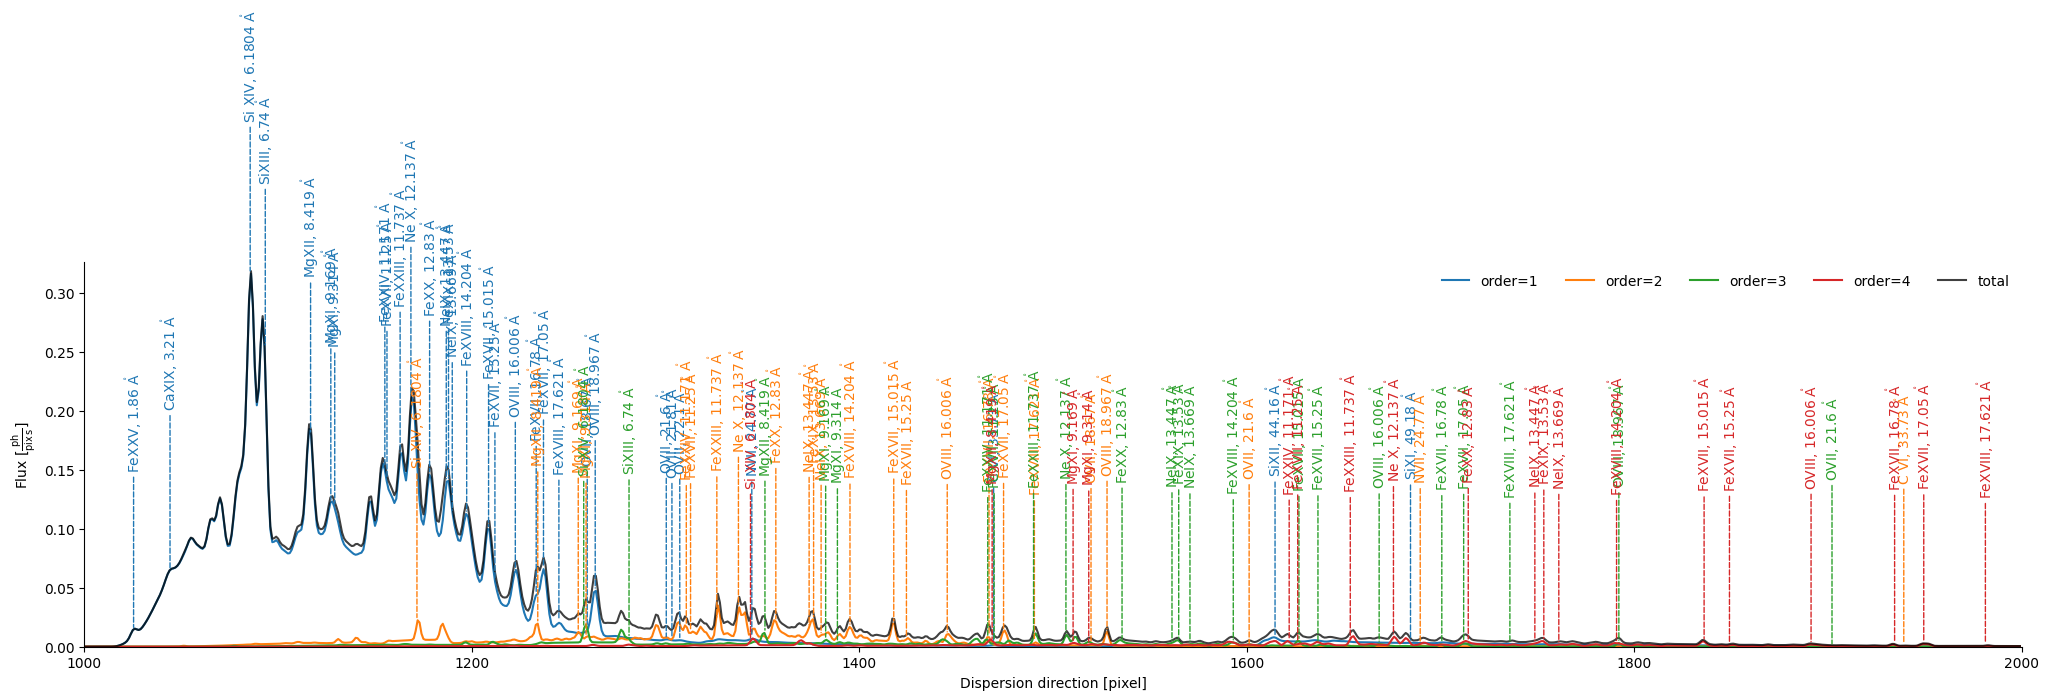

In [14]:
for chianti_spec in [chianti_flare_ext_coronal_spectrum, chianti_flare_ext_photospheric_spectrum]:
    plot_spectrum(chianti_spec,
                  all_channels[5:],
                  source_location, 
                  line_list=line_list, 
                  blur=blur,
                  log_y=False,
                  x_lim=(1000,2000),
                  roll_angle=roll_angle,
                  rel_tol=1e-1,
                  abs_tol=1e-3)

### Caspi Spectra

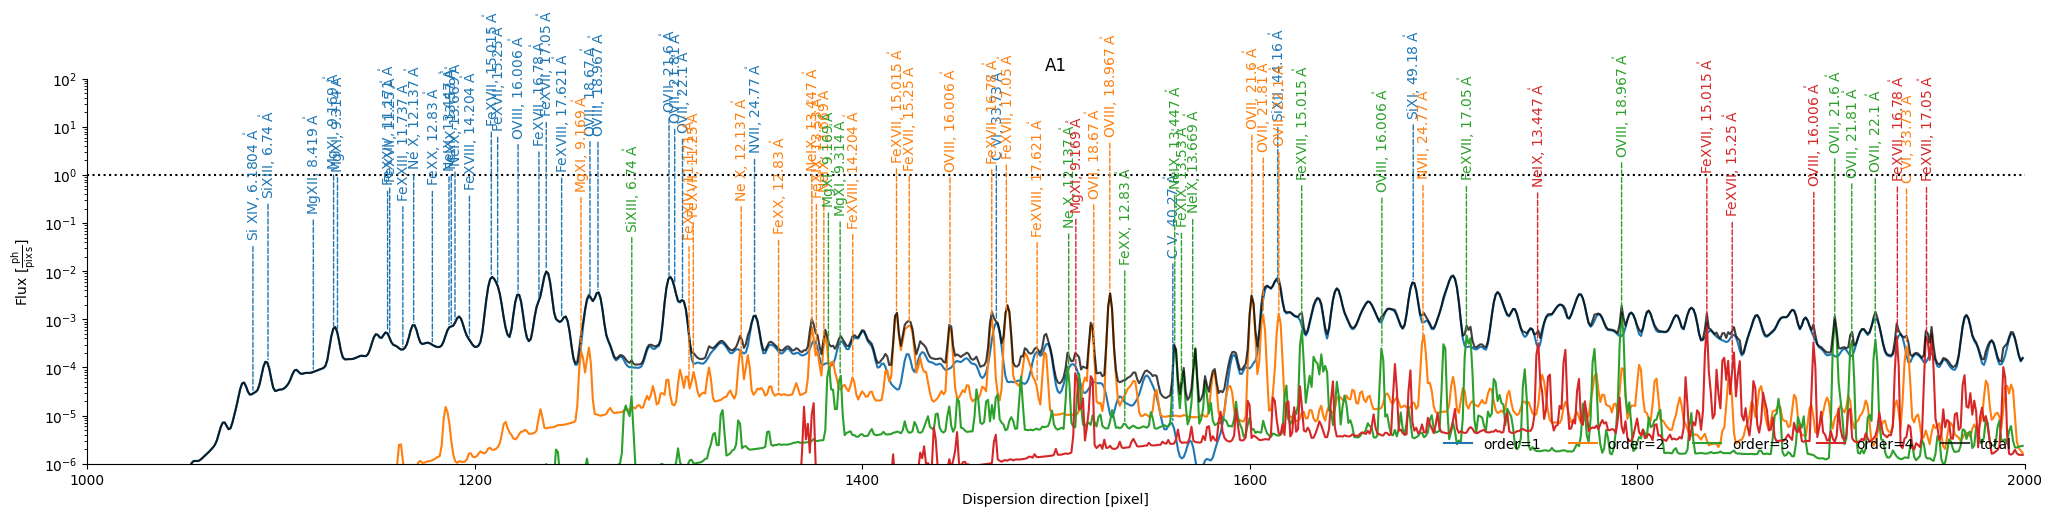

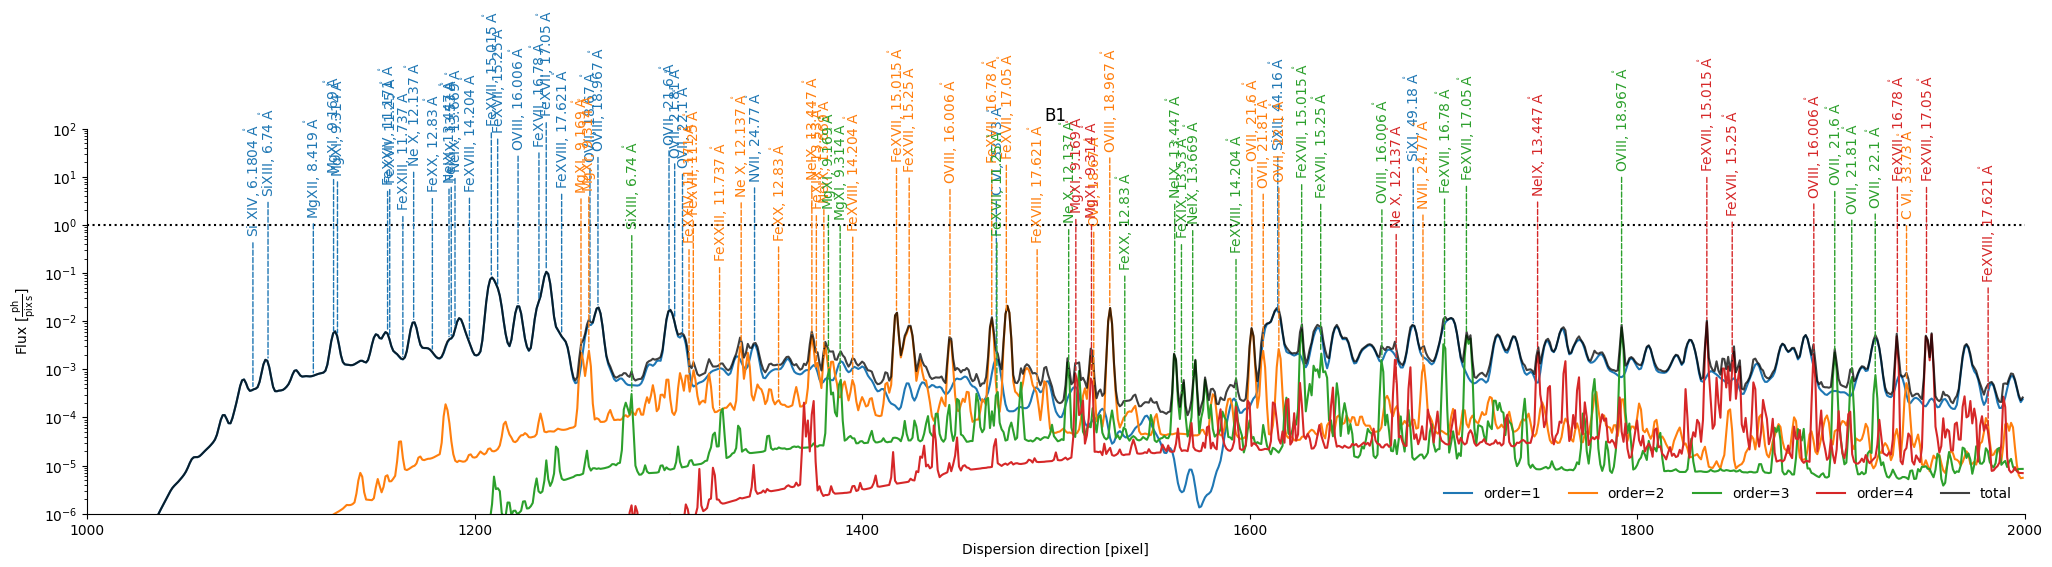

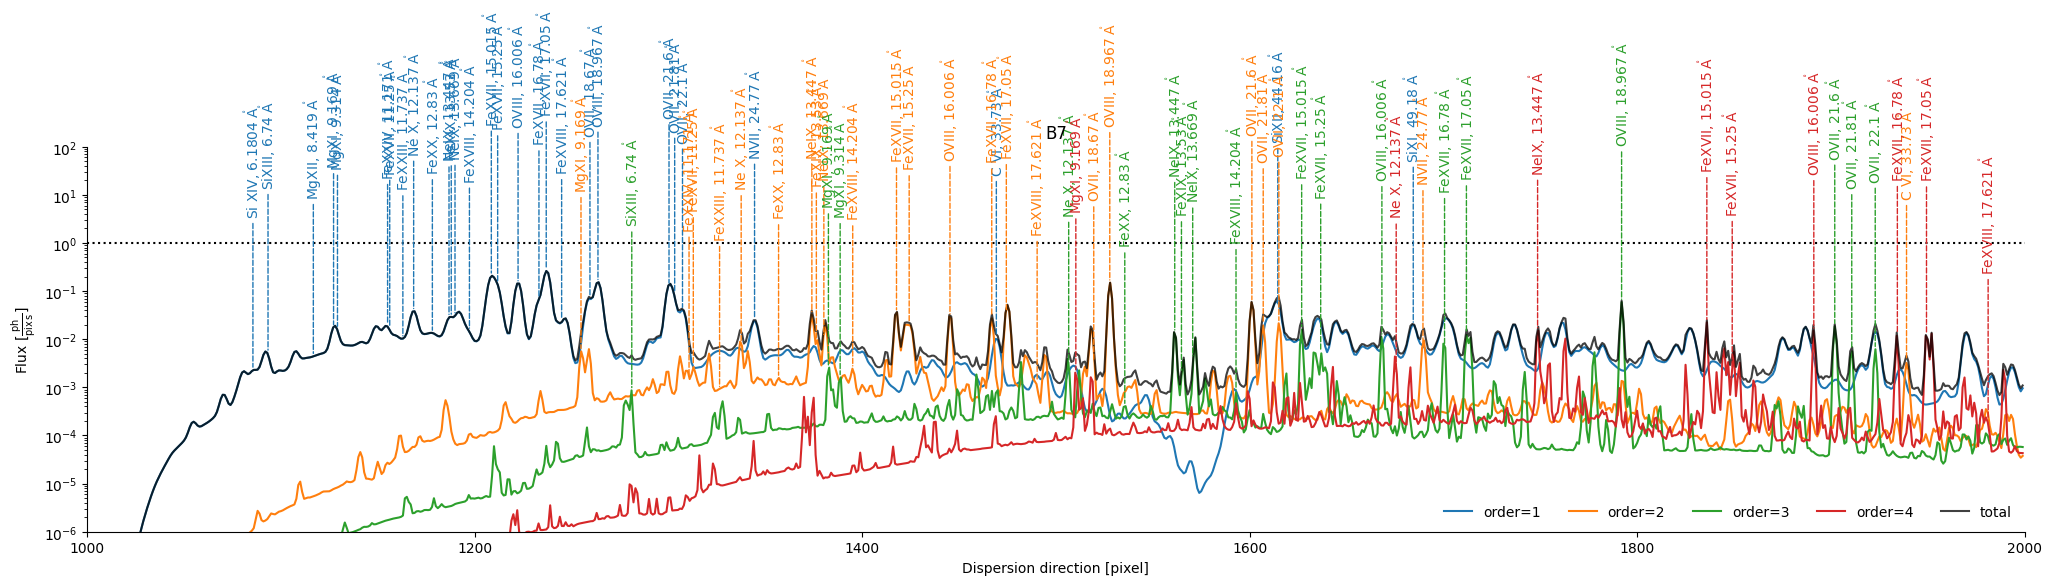

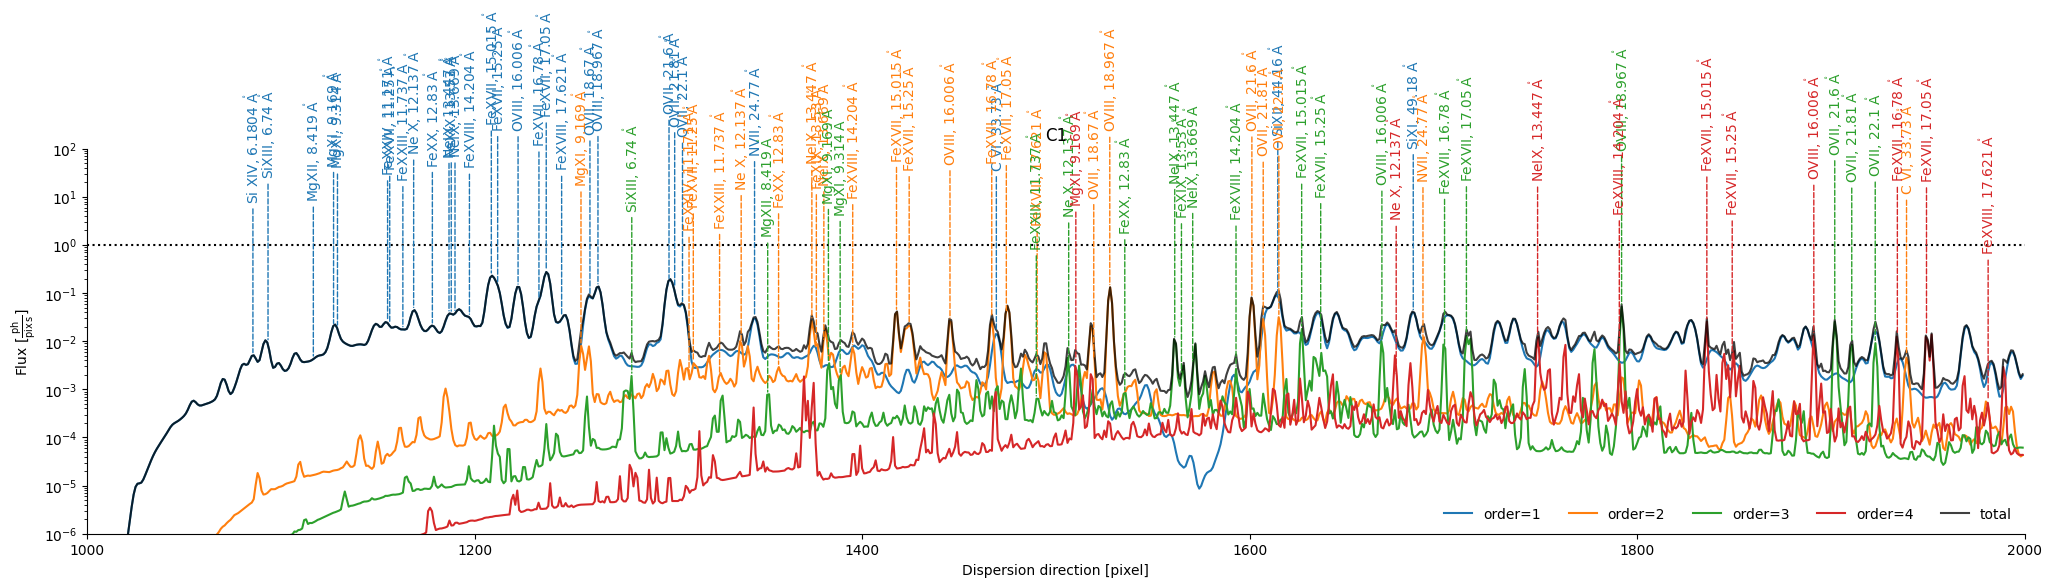

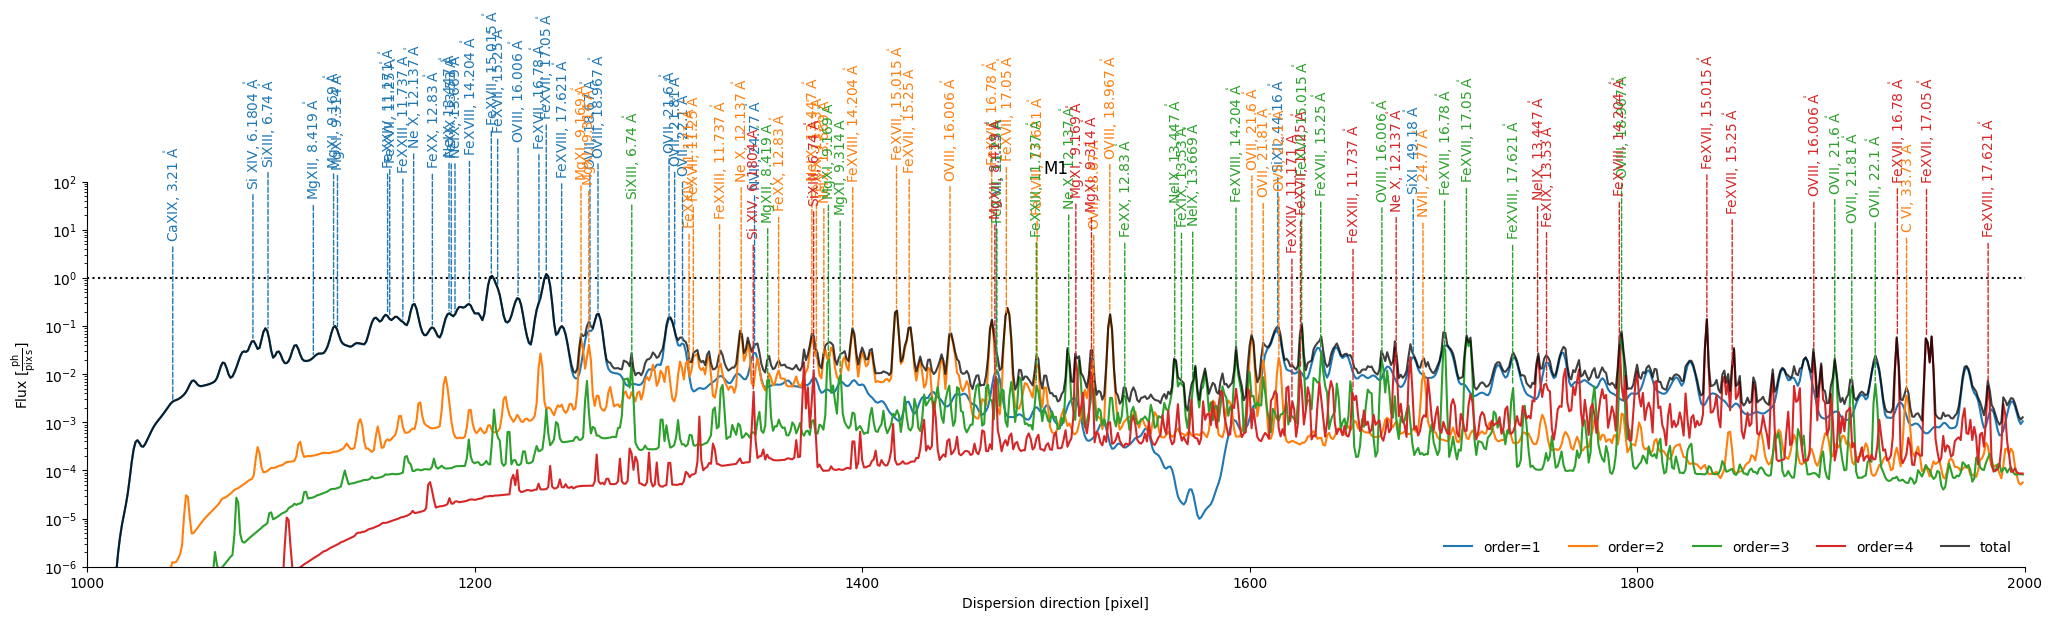

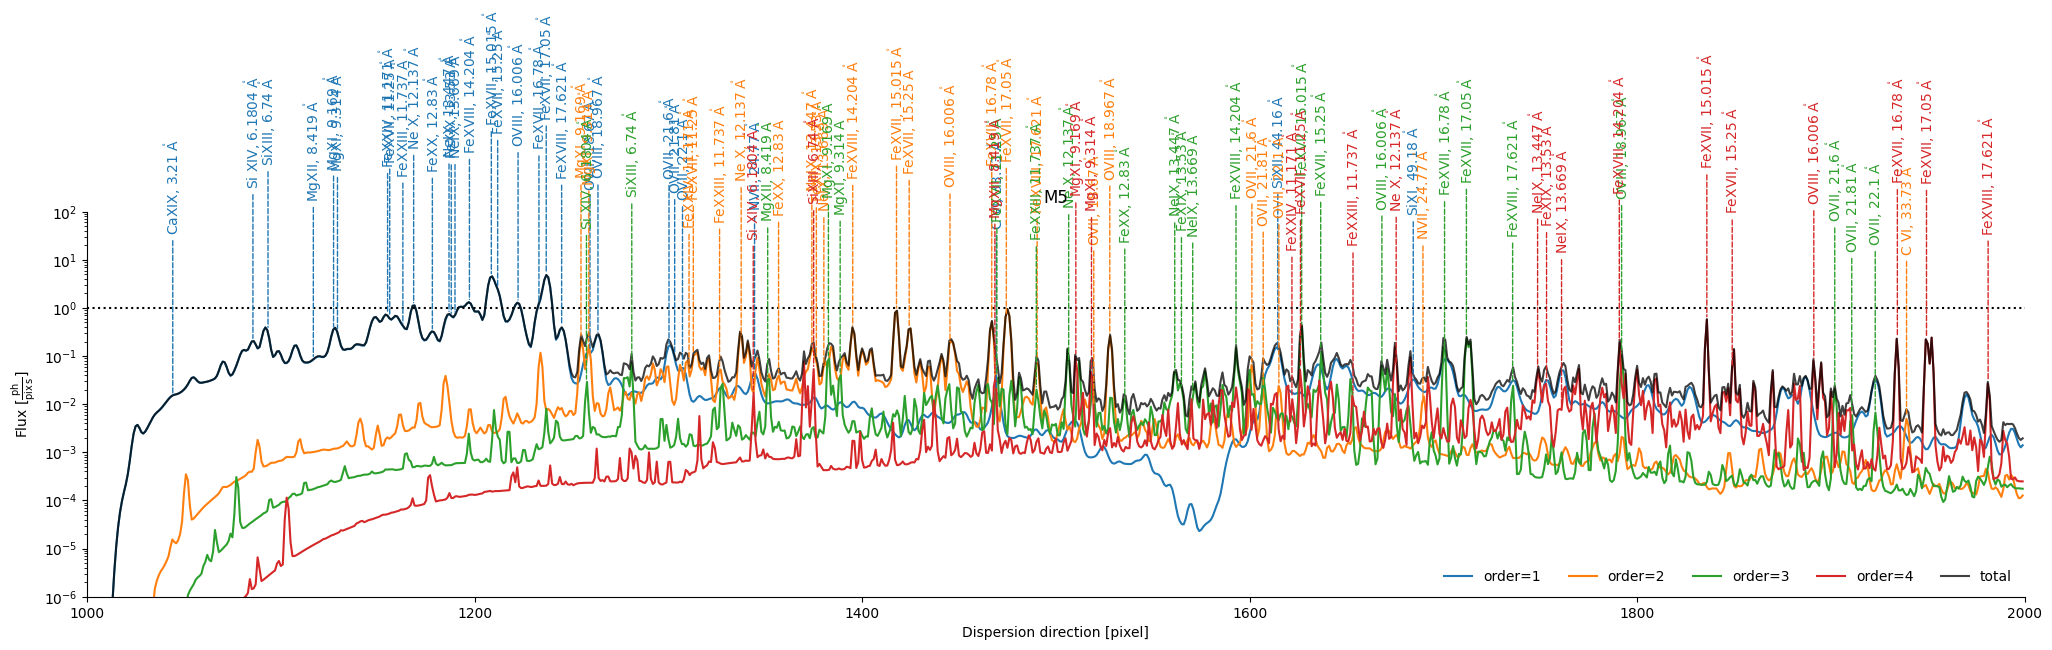

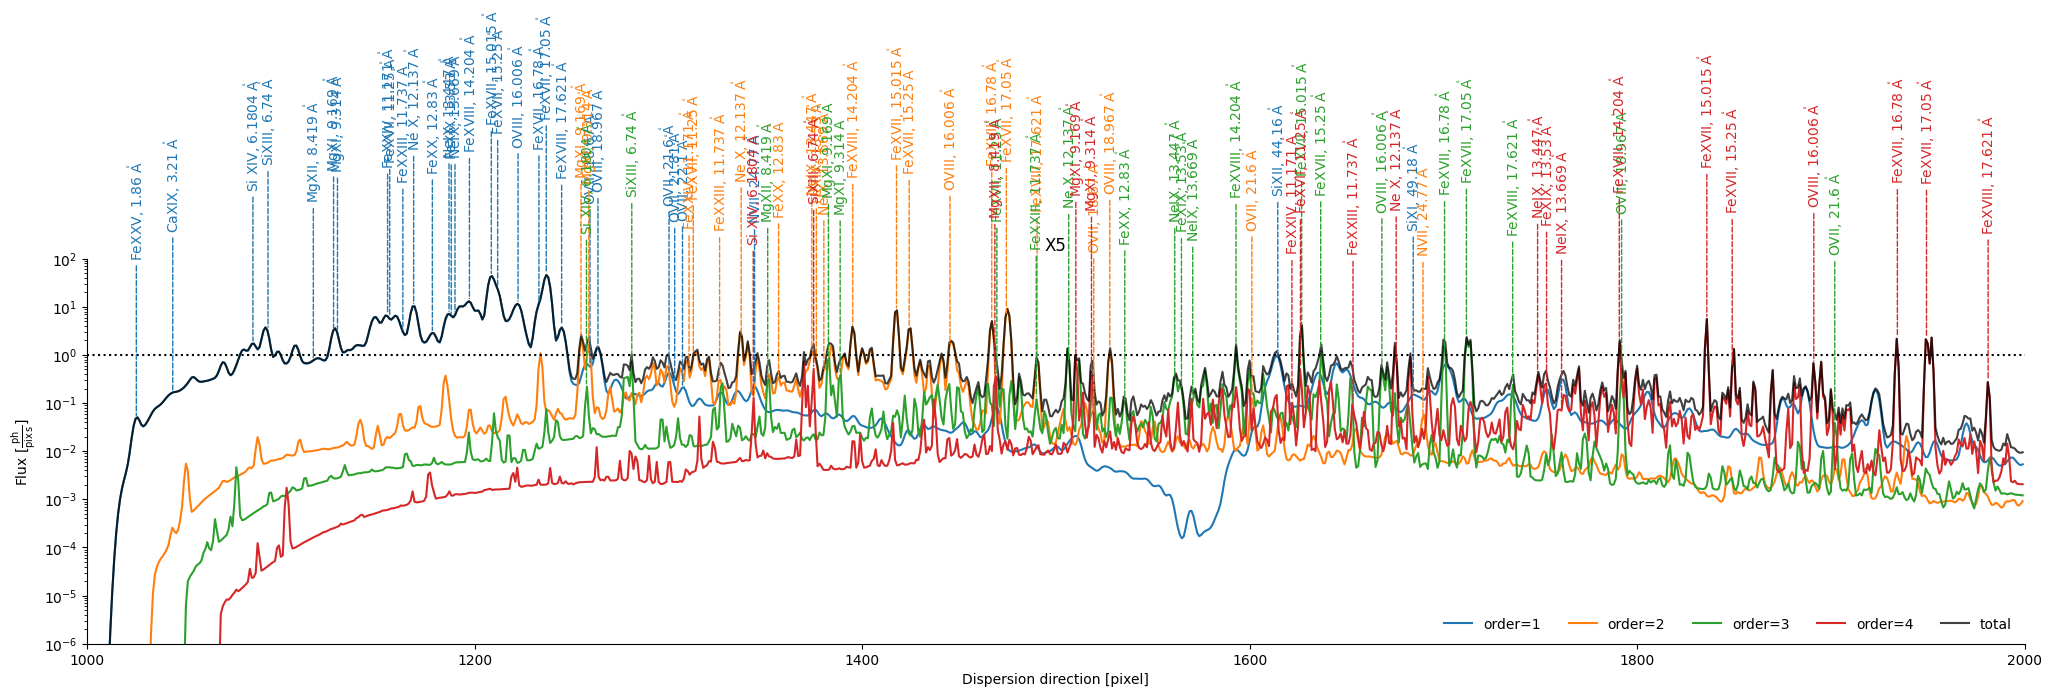

In [16]:
for k in caspi_spectrum:
    plot_spectrum(caspi_spectrum[k],
                  all_channels[5:],
                  source_location, 
                  line_list=line_list, 
                  blur=blur,
                  y_lim=(1e-6,100),
                  log_y=True,
                  x_lim=(1000,2000),
                  roll_angle=roll_angle,
                  rel_tol=1e-1,
                  abs_tol=1e-3,
                  title=k.upper())

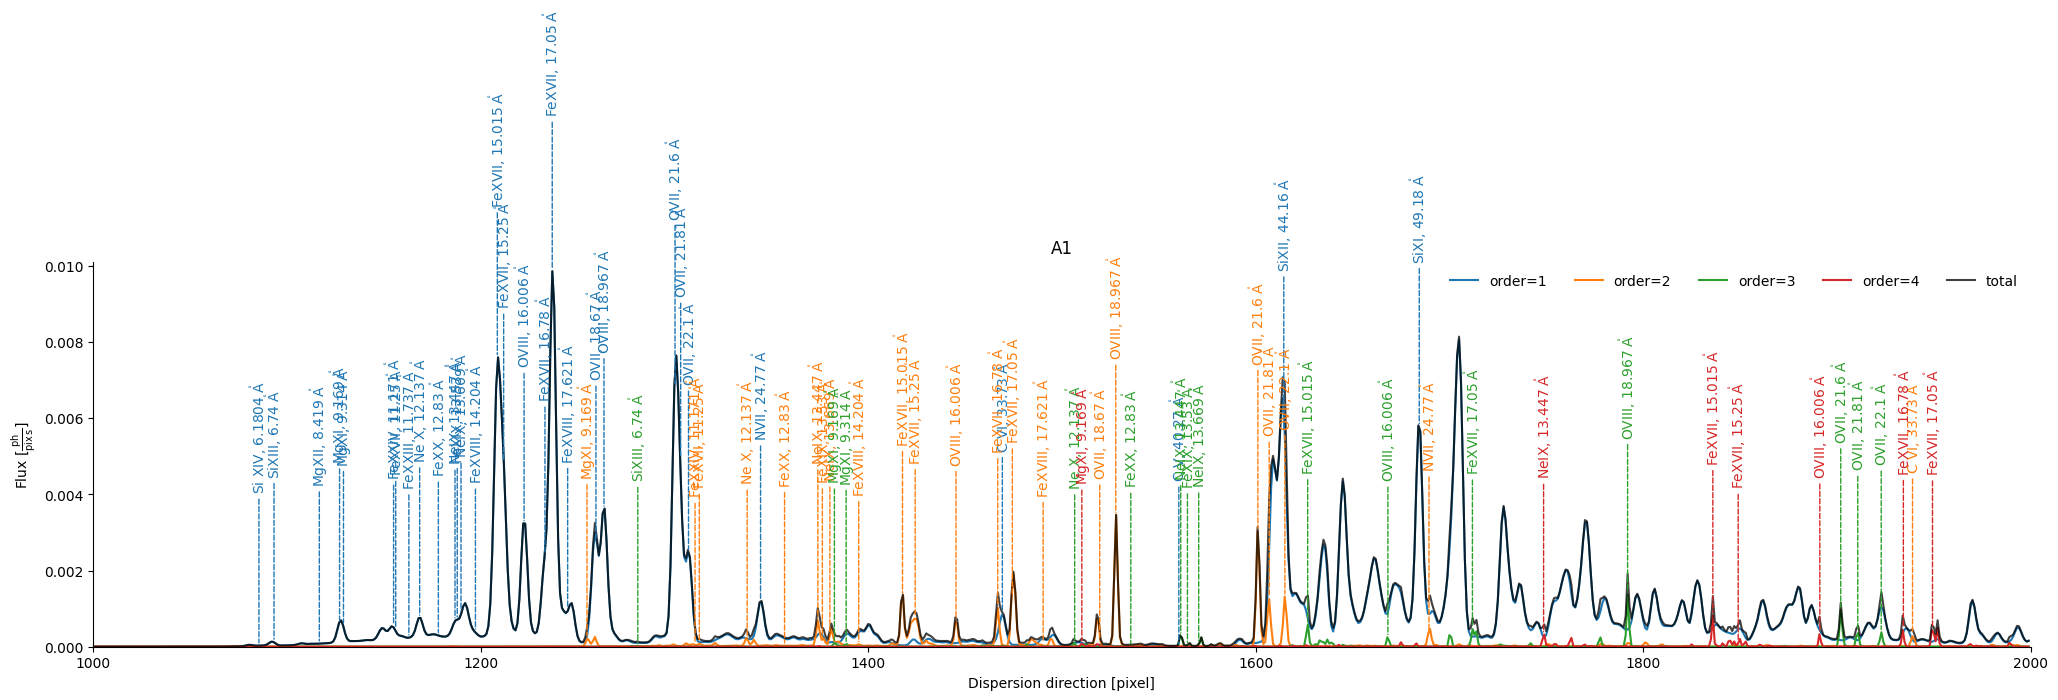

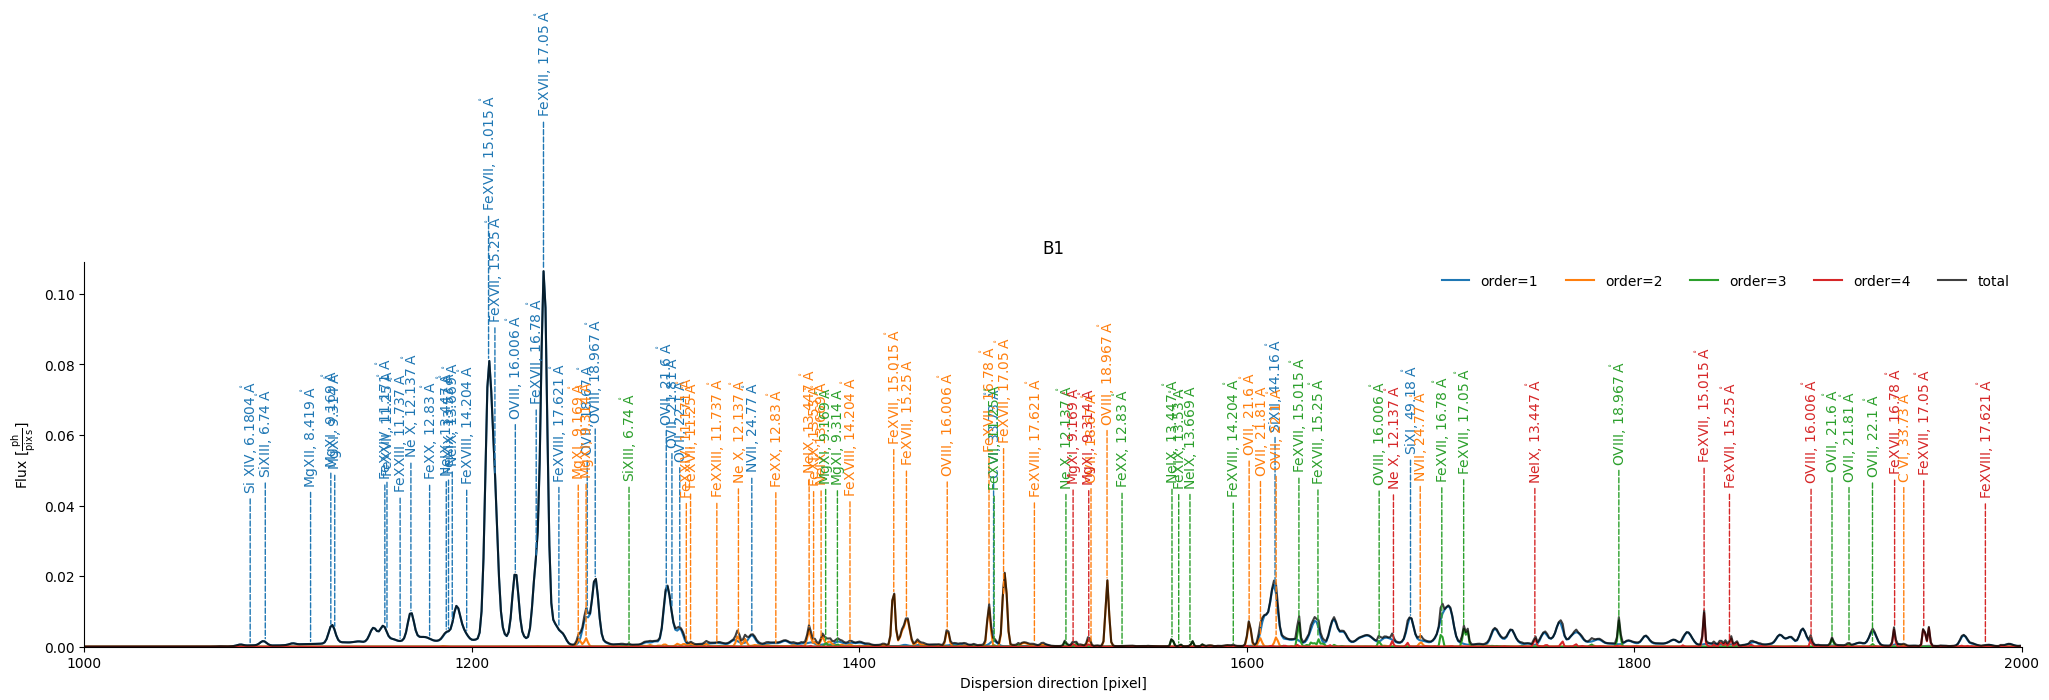

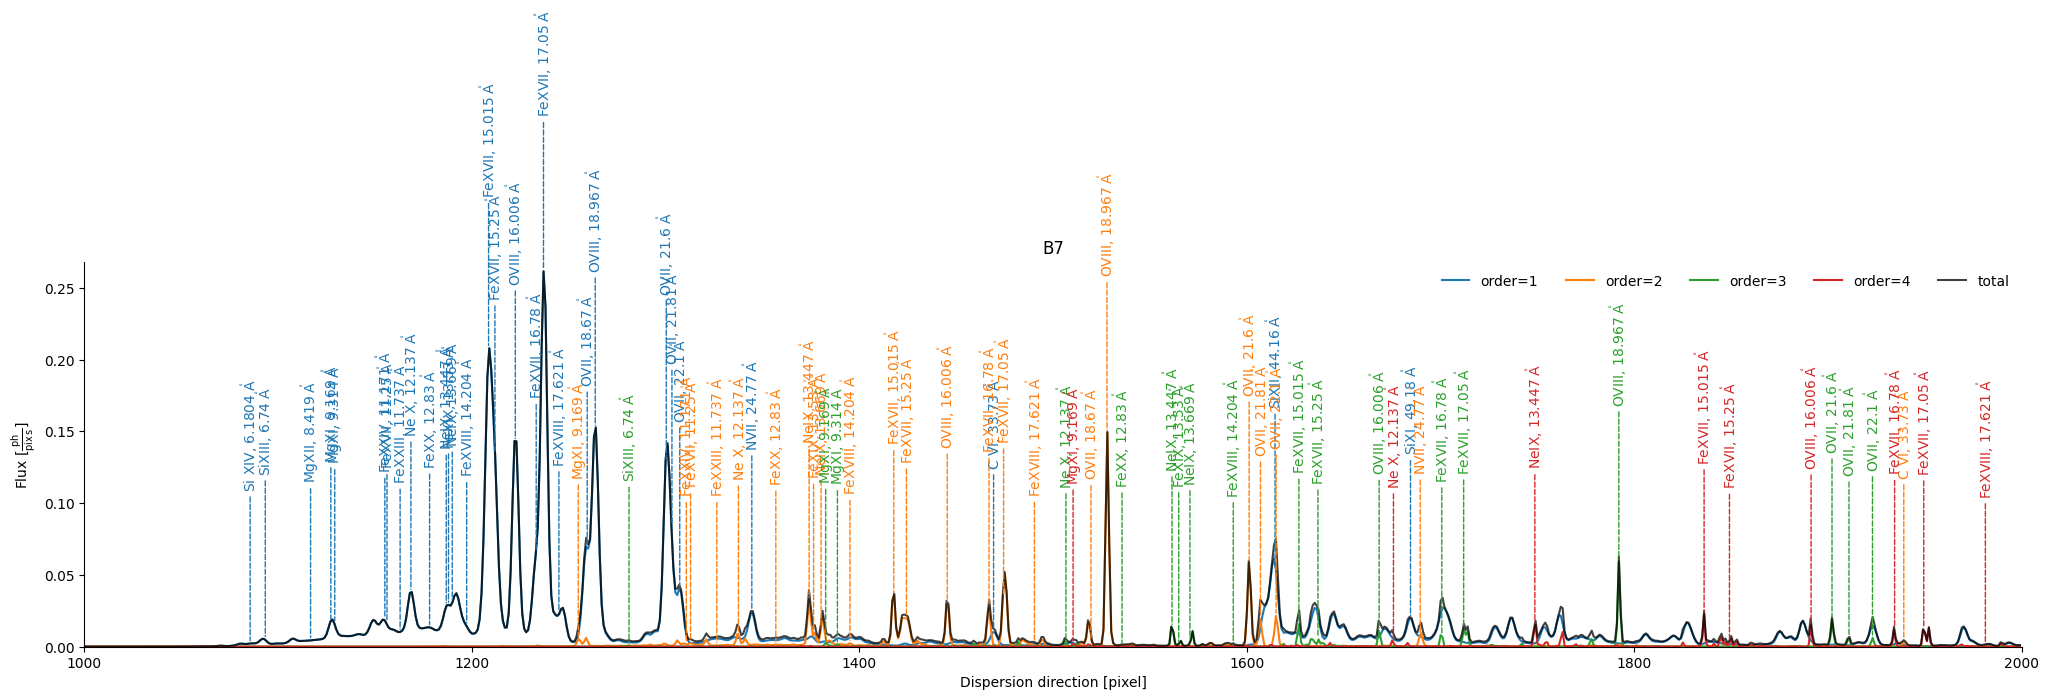

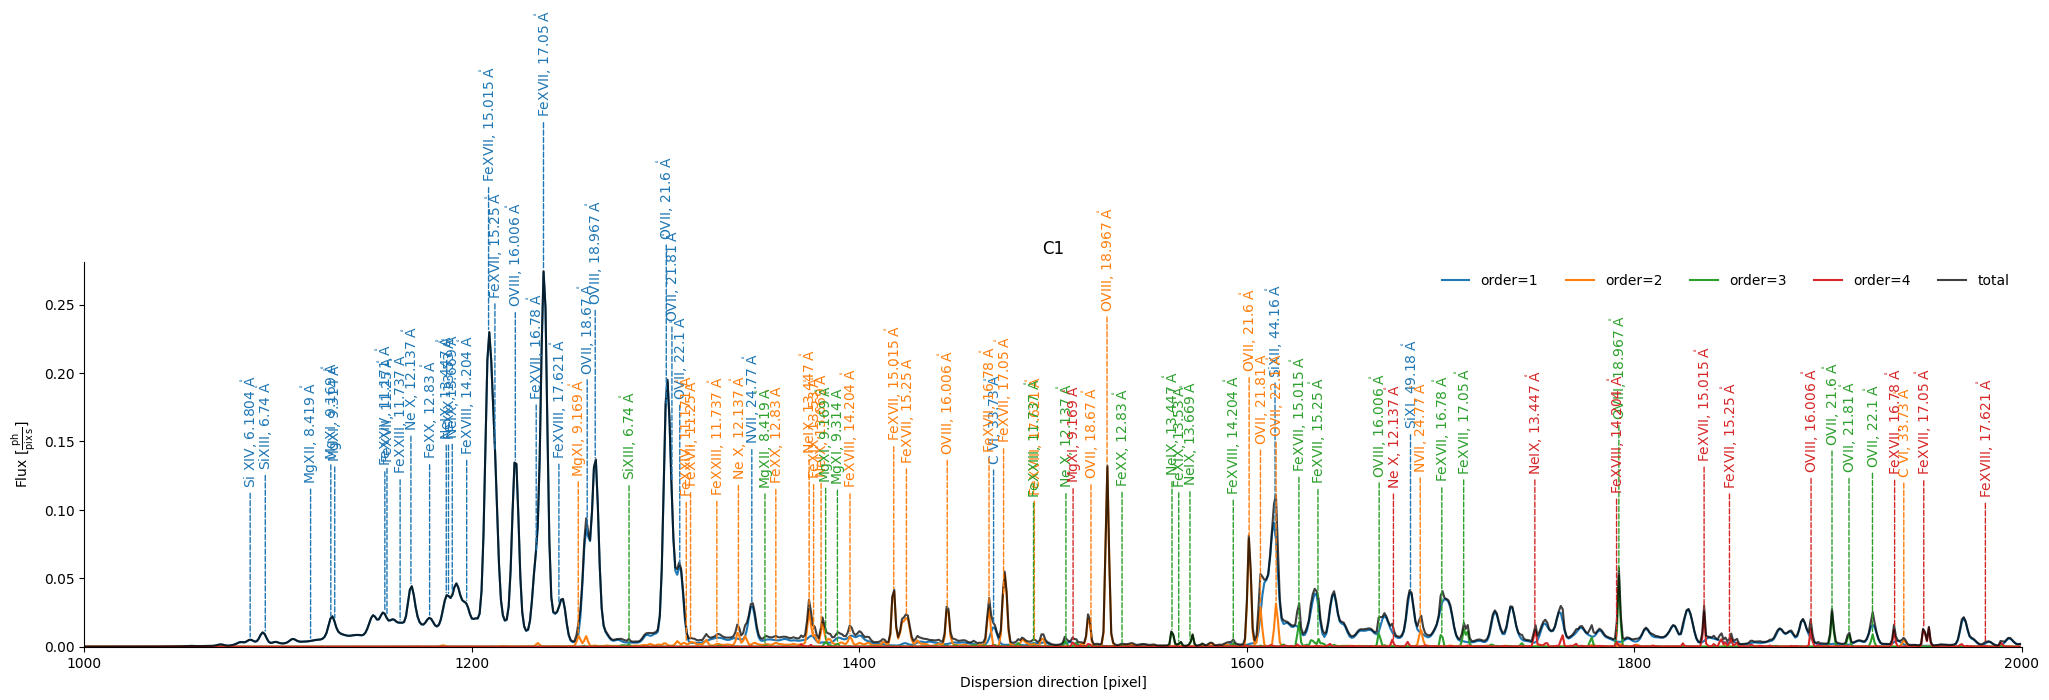

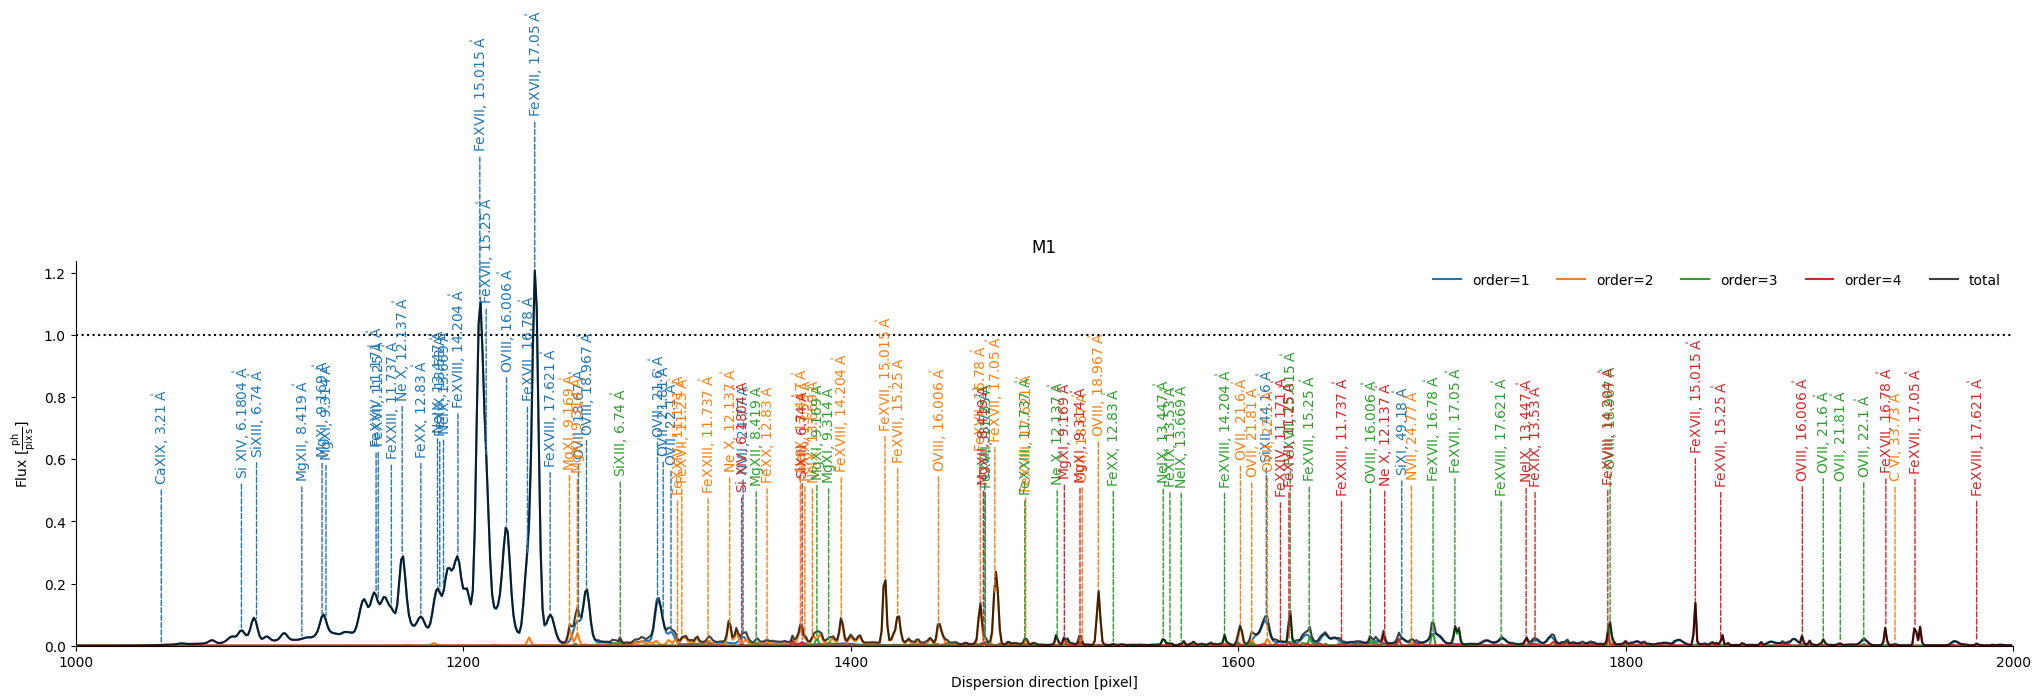

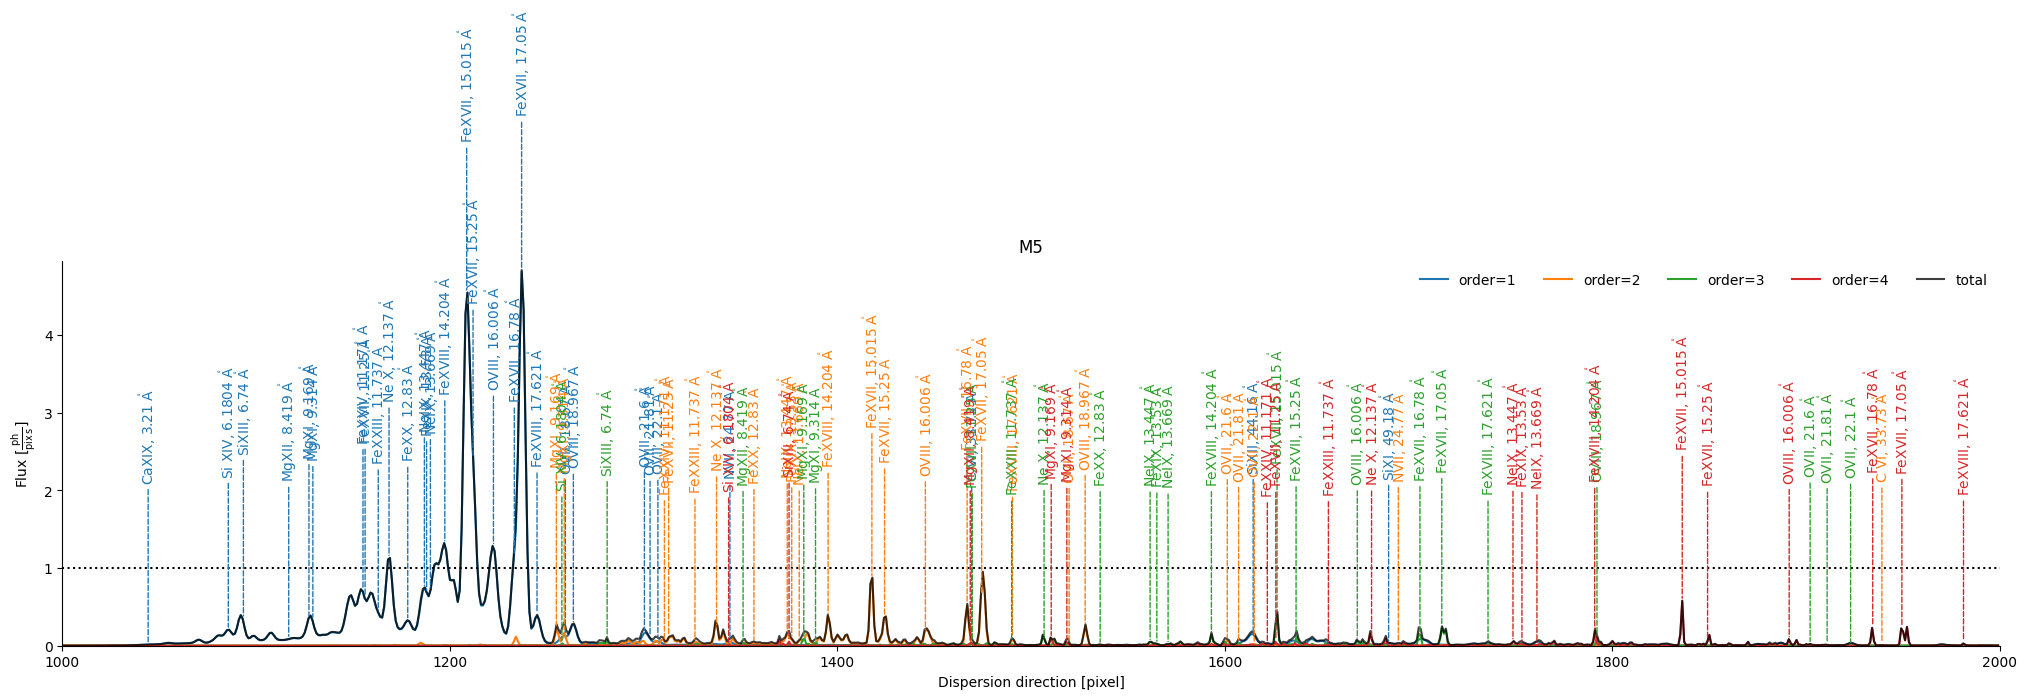

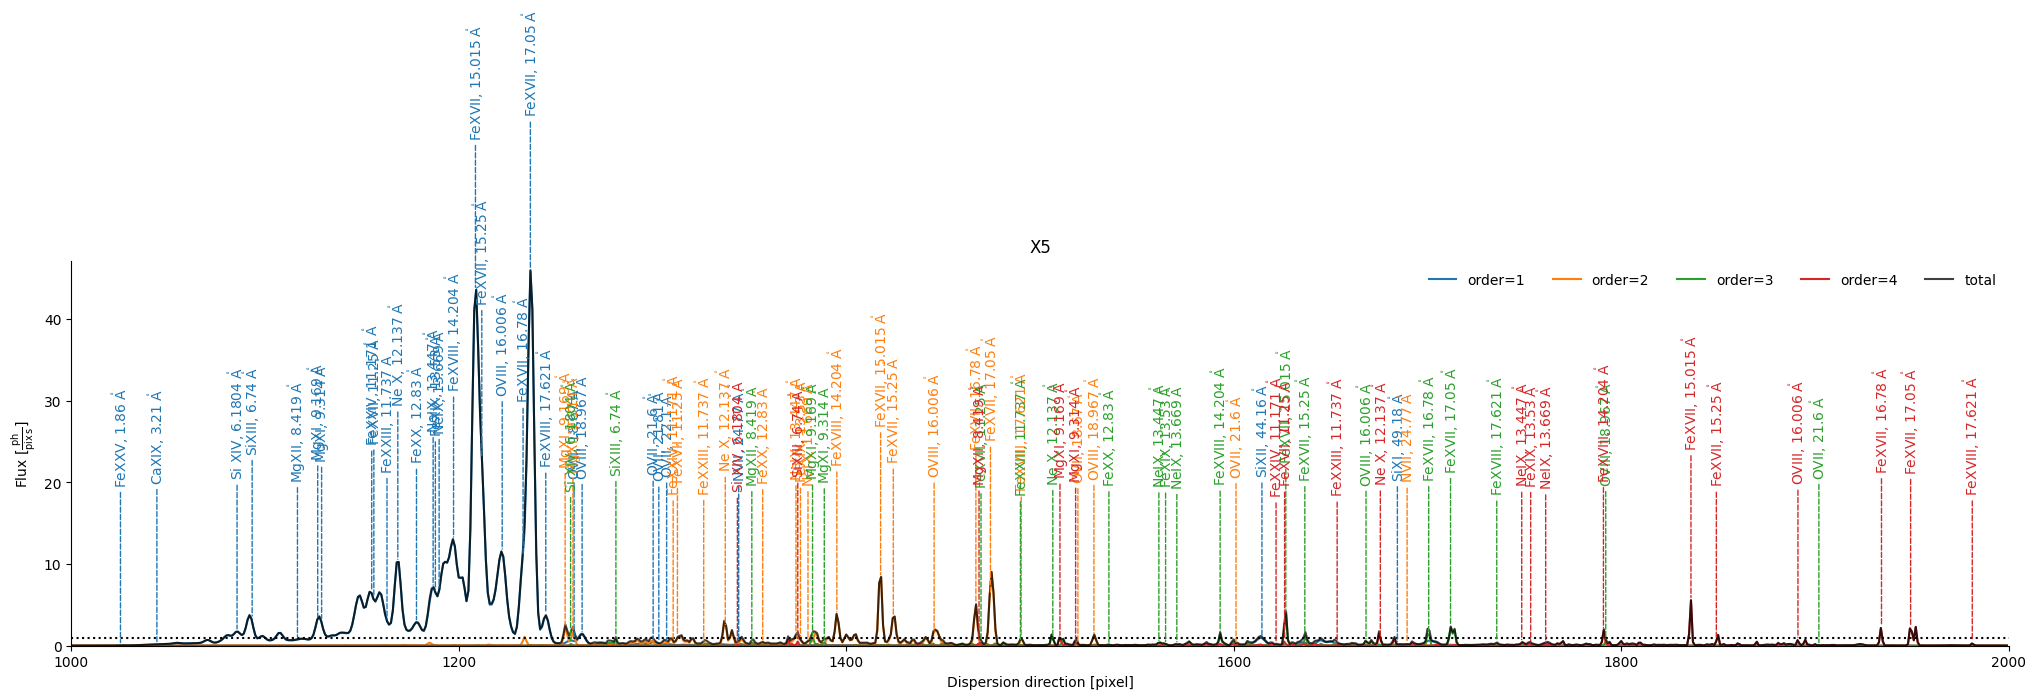

In [17]:
for k in caspi_spectrum:
    plot_spectrum(caspi_spectrum[k],
                  all_channels[5:],
                  source_location, 
                  line_list=line_list, 
                  blur=blur,
                  #y_lim=(1e-6,100),
                  log_y=False,
                  x_lim=(1000,2000),
                  roll_angle=roll_angle,
                  rel_tol=1e-1,
                  abs_tol=1e-3,
                  title=k.upper())

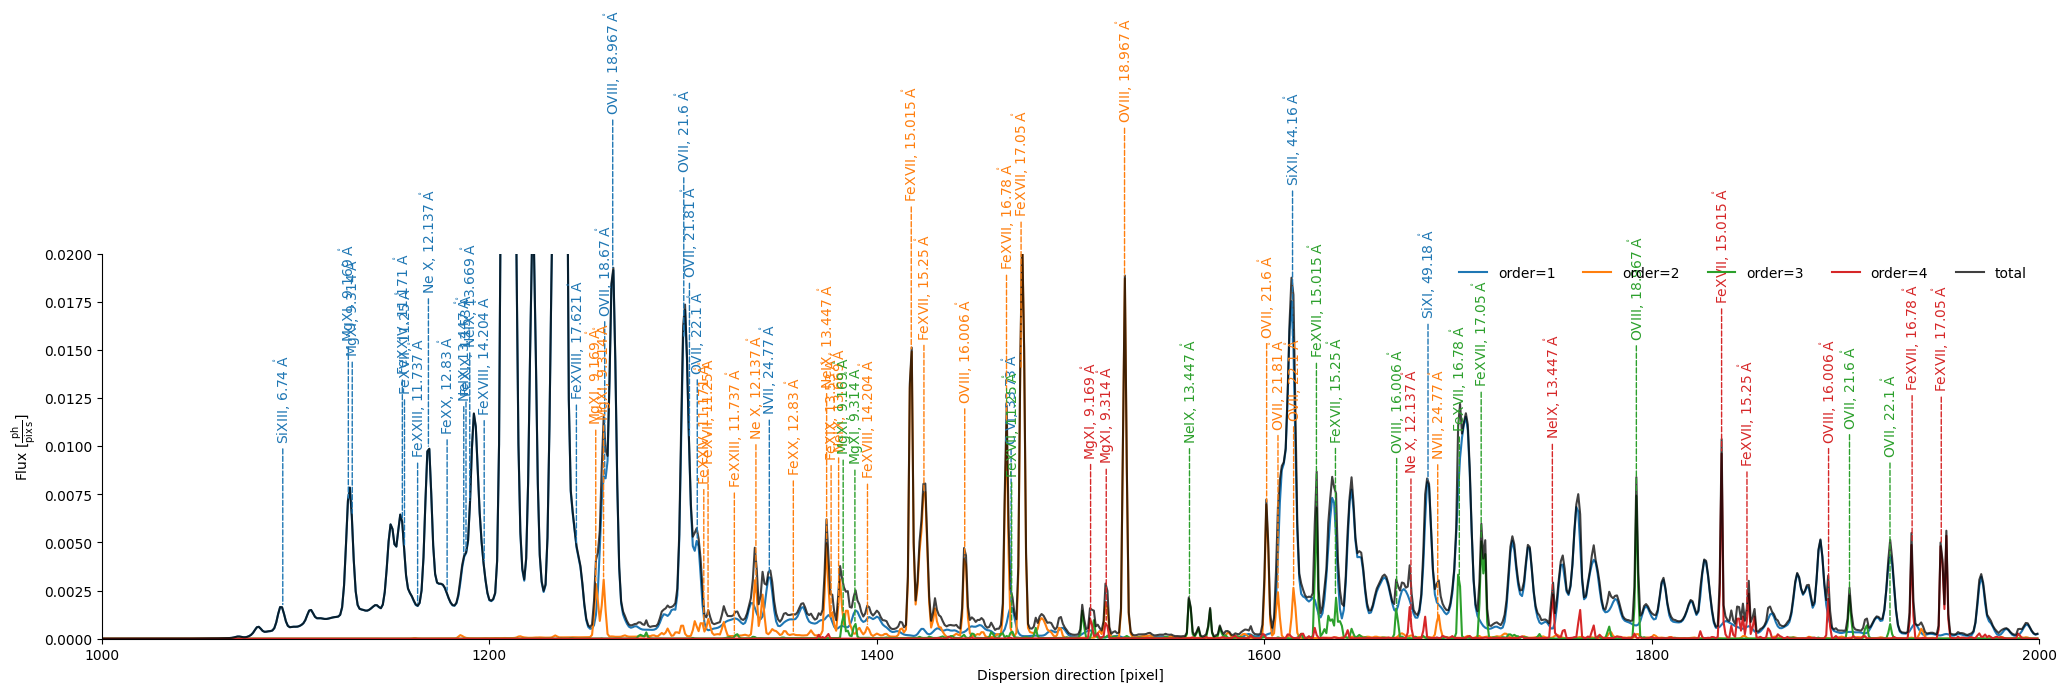

In [39]:
plot_spectrum(caspi_spectrum['b1'],
              all_channels[5:],
              source_location, 
              line_list=line_list, 
              blur=blur,
              y_lim=(0,.02),
              log_y=False,
              x_lim=(1000,2000),
              roll_angle=roll_angle,
              rel_tol=1e-1,
              abs_tol=1e-2,)